In [36]:
# 头发的种类
HAIRS = ['orange hair', 'white hair', 'aqua hair', 'gray hair', 'green hair', 'red hair', 'purple hair', 'pink hair','blue hair', 'black hair', 'brown hair', 'blonde hair']
# 眼睛的种类
EYES = ['gray eyes', 'black eyes', 'orange eyes', 'pink eyes', 'yellow eyes', 'aqua eyes', 'purple eyes', 'green eyes','brown eyes', 'red eyes', 'blue eyes']
print("头发颜色种类有：{0},眼睛颜色种类有：{1}".format(len(HAIRS),len(EYES)))

头发颜色种类有：12,眼睛颜色种类有：11


In [37]:
# 加载标签数据
import numpy as np
import csv
with open('tags_clean.csv', 'r') as file:
    lines = csv.reader(file, delimiter=',')
    y_hairs = []
    y_eyes = []
    y_index = []
    for i, line in enumerate(lines):
        # id 对应的是图片的名字
        idx = line[0]
        # tags 代表图片的所有特征（有hair，eyes，doll等等，当时我们只关注eye 和 hari）
        tags = line[1]
        tags = tags.split('\t')[:-1]
        y_hair = []
        y_eye = []
        for tag in tags:
            tag = tag[:tag.index(':')]
            if (tag in HAIRS):
                y_hair.append(HAIRS.index(tag))
            if (tag in EYES):
                y_eye.append(EYES.index(tag))
        # 如果同时存在hair 和 eye标签就代表这个标签是有用标签。
        if (len(y_hair) == 1 and len(y_eye) == 1):
            y_hairs.append(y_hair)
            y_eyes.append(y_eye)
            y_index.append(i)
    y_eyes = np.array(y_eyes)
    y_hairs = np.array(y_hairs)
    y_index = np.array(y_index)
    print("一种有{0}个有用的标签".format(len(y_index)))

一种有11418个有用的标签


In [38]:
import os
import cv2
# 创建数据集images_data
images_data = np.zeros((len(y_index), 64, 64, 3))
# 从本地文件读取图片加载到images_data中。
for index,file_index in enumerate (y_index):
    images_data[index] = cv2.cvtColor(
        cv2.resize(
            cv2.imread(os.path.join("faces", str(file_index) + '.jpg'), cv2.IMREAD_COLOR),
            (64, 64)),cv2.COLOR_BGR2RGB
            )

In [39]:
images_data = (images_data / 127.5) - 1

In [57]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Activation
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import Conv2D, Conv2DTranspose, Dropout, UpSampling2D, MaxPooling2D,Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import to_categorical,plot_model
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [41]:

def build_generator_model(noise_dim, hair_num_class, eye_num_class):
    """
    定义generator的生成方法
    :param noise_dim: 噪声的维度
    :param hair_num_class: hair标签的种类个数
    :param eye_num_class: eye标签的种类个数
    :return: generator
    """
    # kernel初始化模式
    kernel_init = 'glorot_uniform'

    model = Sequential(name='generator')

    model.add(Reshape((1, 1, -1), input_shape=(noise_dim + 16,)))
    model.add(Conv2DTranspose(filters=512, kernel_size=(4, 4), strides=(1, 1), padding="valid",
                              data_format="channels_last", kernel_initializer=kernel_init, ))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(filters=256, kernel_size=(4, 4), strides=(2, 2), padding="same",
                              data_format="channels_last", kernel_initializer=kernel_init))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(filters=128, kernel_size=(4, 4), strides=(2, 2), padding="same",
                              data_format="channels_last", kernel_initializer=kernel_init))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same",
                              data_format="channels_last", kernel_initializer=kernel_init))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", data_format="channels_last",
                     kernel_initializer=kernel_init))
    model.add(BatchNormalization(momentum=0.5))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(filters=3, kernel_size=(4, 4), strides=(2, 2), padding="same",
                              data_format="channels_last", kernel_initializer=kernel_init))
    model.add(Activation('tanh'))

    latent = Input(shape=(noise_dim,))
    eyes_class = Input(shape=(1,), dtype='int32')
    hairs_class = Input(shape=(1,), dtype='int32')

    hairs = Flatten()(Embedding(hair_num_class, 8, init='glorot_normal')(hairs_class))
    eyes = Flatten()(Embedding(eye_num_class, 8, init='glorot_normal')(eyes_class))
    # 连接模型的输入
    con = Concatenate()([latent, hairs, eyes])
    # 模型的输出
    fake_image = model(con)
    # 创建模型
    m = Model(input=[latent, hairs_class, eyes_class], output=fake_image)
    return m

In [42]:
# 生成网络
G = build_generator_model(100,len(HAIRS),len(EYES))
# 
plot_model(G, to_file='generator.png', show_shapes=True, expand_nested=True, dpi=500)

In [43]:
def build_discriminator_model(hair_num_class, eye_num_class):
    """
    定义生成 discriminator 的方法
    :param hair_num_class: 头发颜色的种类
    :param eye_num_class: 眼睛颜色的种类
    :return: discriminator
    """
    kernel_init = 'glorot_uniform'
    discriminator_model = Sequential(name="discriminator_model")
    discriminator_model.add(Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same",
                                   data_format="channels_last", kernel_initializer=kernel_init,
                                   input_shape=(64, 64, 3)))
    discriminator_model.add(LeakyReLU(0.2))
    discriminator_model.add(Conv2D(filters=128, kernel_size=(4, 4), strides=(2, 2), padding="same",
                                   data_format="channels_last", kernel_initializer=kernel_init))
    discriminator_model.add(BatchNormalization(momentum=0.5))
    discriminator_model.add(LeakyReLU(0.2))
    discriminator_model.add(Conv2D(filters=256, kernel_size=(4, 4), strides=(2, 2), padding="same",
                                   data_format="channels_last", kernel_initializer=kernel_init))
    discriminator_model.add(BatchNormalization(momentum=0.5))
    discriminator_model.add(LeakyReLU(0.2))
    discriminator_model.add(Conv2D(filters=512, kernel_size=(4, 4), strides=(2, 2), padding="same",
                                   data_format="channels_last", kernel_initializer=kernel_init))
    discriminator_model.add(BatchNormalization(momentum=0.5))
    discriminator_model.add(LeakyReLU(0.2))
    discriminator_model.add(Flatten())
    # 网络的输入
    dis_input = Input(shape=(64, 64, 3))

    features = discriminator_model(dis_input)
    # 真/假概率的输出
    validity = Dense(1, activation="sigmoid")(features)
    # 头发颜色种类的输出
    label_hair = Dense(hair_num_class, activation="softmax")(features)
    # 眼睛颜色种类的输出
    label_eyes = Dense(eye_num_class, activation="softmax")(features)
    m = Model(dis_input, [validity, label_hair, label_eyes])
    return m

In [44]:
D = build_discriminator_model(len(HAIRS),len(EYES))
# plot_model(D, to_file='discriminator.png', show_shapes=True, expand_nested=True, dpi=500)

In [45]:
def build_ACGAN(gen_lr=0.00015, dis_lr=0.0002, noise_size=100):
    """
    生成
    :param gen_lr: generator的学习率
    :param dis_lr: discriminator的学习率
    :param noise_size: 噪声维度size
    :return:
    """
    gen_opt = Adam(lr=gen_lr, beta_1=0.5)
    G.compile(loss='binary_crossentropy', optimizer=gen_opt, metrics=['accuracy'])

    dis_opt = Adam(lr=dis_lr, beta_1=0.5)
    losses = ['binary_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy']
    D.compile(loss=losses, loss_weights=[1.4, 0.8, 0.8], optimizer=dis_opt, metrics=['accuracy'])
    # 在训练的generator，冻结discriminator的权重
    D.trainable = False

    opt = Adam(lr=gen_lr, beta_1=0.5)
    gen_inp = Input(shape=(noise_size,))
    hairs_inp = Input(shape=(1,), dtype='int32')
    eyes_inp = Input(shape=(1,), dtype='int32')
    GAN_inp = G([gen_inp, hairs_inp, eyes_inp])
    GAN_opt = D(GAN_inp)
    gan = Model(input=[gen_inp, hairs_inp, eyes_inp], output=GAN_opt)
    gan.compile(loss=losses, optimizer=opt, metrics=['accuracy'])
    return gan

In [46]:
gan = build_ACGAN()

# plot_model(gan, to_file='gan.png', show_shapes=True, expand_nested=True, dpi=500)

In [62]:
def gen_noise(batch_size, noise_size=100):
    """
    生成高斯噪声
    :param batch_size: 生成噪声的数量
    :param noise_size: 噪声的维度
    :return: （batch_size,noise）的高斯噪声
    """
    return np.random.normal(0, 1, size=(batch_size, noise_size))


def generate_images(generator,img_path):
    """
    G网络生成图片
    :param generator: 生成器
    :return: （64，64，3）维度 16张图片
    """
    noise = gen_noise(16, 100)
    hairs = np.zeros(16)
    eyes = np.zeros(16)

    # 指令生成头发，和眼睛的颜色
    for h in range(len(HAIRS)):
        hairs[h] = h

    for e in range(len(EYES)):
        eyes[e] = e
    # 生成图片
    fake_data_X = generator.predict([noise, hairs, eyes])
    plt.figure(figsize=(4, 4))
    gs1 = gridspec.GridSpec(4, 4)
    gs1.update(wspace=0, hspace=0)
    for i in range(16):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        image = fake_data_X[i, :, :, :]
        fig = plt.imshow(image)
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    # 保存图片
    plt.savefig(img_path, bbox_inches='tight', pad_inches=0)


def sample_from_dataset(batch_size, images, hair_tags, eye_tags):
    """
    从数据集中随机获取图片
    :param batch_size: 批处理大小
    :param images: 数据集
    :param hair_tags: 头发颜色标签数据集
    :param eye_tags: 眼睛颜色标签数据集
    :return:
    """
    choice_indices = np.random.choice(len(images), batch_size)
    sample = images[choice_indices]
    y_hair_label = hair_tags[choice_indices]
    y_eyes_label = eye_tags[choice_indices]
    return sample, y_hair_label, y_eyes_label


In [53]:
def train(epochs, batch_size, noise_size, hair_num_class, eye_num_class):
    """
    进行训练
    :param epochs: 训练的步数
    :param batch_size: 训练的批处理大小
    :param noise_size: 噪声维度大小
    :param hair_num_class: 头发颜色种类
    :param eye_num_class: 眼睛颜色种类
    :return:
    """
    for step in range(0, epochs):

        # 每隔100轮保存数据
        if (step % 100) == 0:
            step_num = str(step).zfill(6)
            generate_images(G, os.path.join("./generate_img", step_num + "_img.png"))

        # 随机产生数据并进行编码
        sampled_label_hairs = np.random.randint(0, hair_num_class, batch_size).reshape(-1, 1)
        sampled_label_eyes = np.random.randint(0, eye_num_class, batch_size).reshape(-1, 1)
        sampled_label_hairs_cat = to_categorical(sampled_label_hairs, num_classes=hair_num_class)
        sampled_label_eyes_cat = to_categorical(sampled_label_eyes, num_classes=eye_num_class)
        noise = gen_noise(batch_size, noise_size)
        # G网络生成图片
        fake_data_X = G.predict([noise, sampled_label_hairs, sampled_label_eyes])

        # 随机获得真实数据并进行编码
        real_data_X, real_label_hairs, real_label_eyes = sample_from_dataset(
            batch_size, images_data, y_hairs, y_eyes)
        real_label_hairs_cat = to_categorical(real_label_hairs, num_classes=hair_num_class)
        real_label_eyes_cat = to_categorical(real_label_eyes, num_classes=eye_num_class)

        # 产生0，1标签并进行smooth
        real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size) * 0.2
        fake_data_Y = np.random.random_sample(batch_size) * 0.2

        # 训练D网络
        dis_metrics_real = D.train_on_batch(real_data_X, [real_data_Y, real_label_hairs_cat,
                                                          real_label_eyes_cat])
        dis_metrics_fake = D.train_on_batch(fake_data_X, [fake_data_Y, sampled_label_hairs_cat,
                                                          sampled_label_eyes_cat])


        noise = gen_noise(batch_size, noise_size)
        # 产生随机的hair 和 eyes标签
        sampled_label_hairs = np.random.randint(0, hair_num_class, batch_size).reshape(-1, 1)
        sampled_label_eyes = np.random.randint(0, eye_num_class, batch_size).reshape(-1, 1)

        # 将标签变成（，12）或者（，11）类型的
        sampled_label_hairs_cat = to_categorical(sampled_label_hairs, num_classes=hair_num_class)
        sampled_label_eyes_cat = to_categorical(sampled_label_eyes, num_classes=eye_num_class)

        real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size) * 0.2
        # GAN网络的输入
        GAN_X = [noise, sampled_label_hairs, sampled_label_eyes]
        # GAN网络的输出
        GAN_Y = [real_data_Y, sampled_label_hairs_cat, sampled_label_eyes_cat]
        # 对GAN网络进行训练
        gan_metrics = gan.train_on_batch(GAN_X, GAN_Y)

        # 保存生成器
        if step % 100 == 0:
            print("Step: ", step)
            print("Discriminator: real/fake loss %f, %f" % (dis_metrics_real[0], dis_metrics_fake[0]))
            print("GAN loss: %f" % (gan_metrics[0]))
            G.save(os.path.join('./model', str(step) + "_GENERATOR.hdf5"))

alid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range

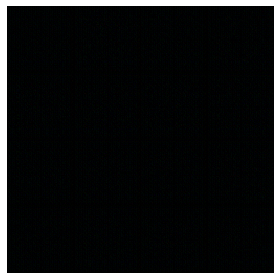

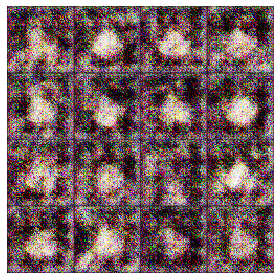

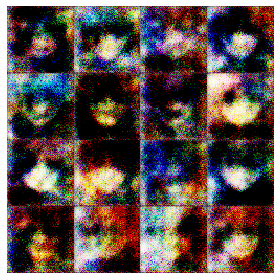

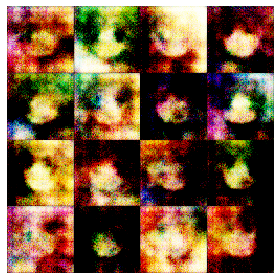

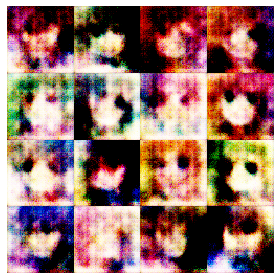

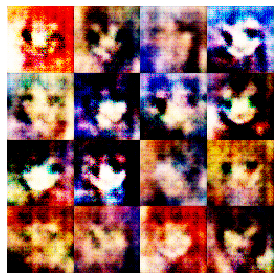

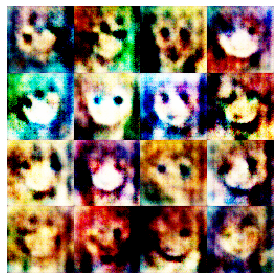

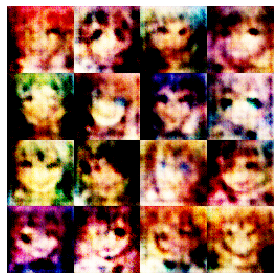

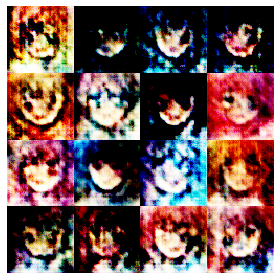

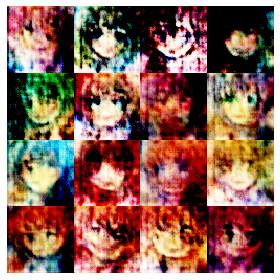

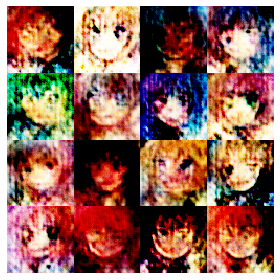

In [64]:
train(1000000,64,100,len(HAIRS),len(EYES))